In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('data/IncidentiModificato.xlsx')
df.DATA = df.DATA.apply(lambda d: (d - dt.datetime(1970,1,1)).days)

X = df[['DATA','SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'BMI', 'Tot Testa', 'Tot Torace', 'Tot Addome', 'Tot Scheletro']]
y = df['Mezzo']

Qui ho provato a visualizzare i dati e ho notato che la data è l'attributo che discrimina di più (infatti se lo togliamo l'accuratezza della rete neurale diminuisce). Guardando gli scatterplot si nota che tra le prime date ci sono quasi solo persone classificate con mezzo = 1.

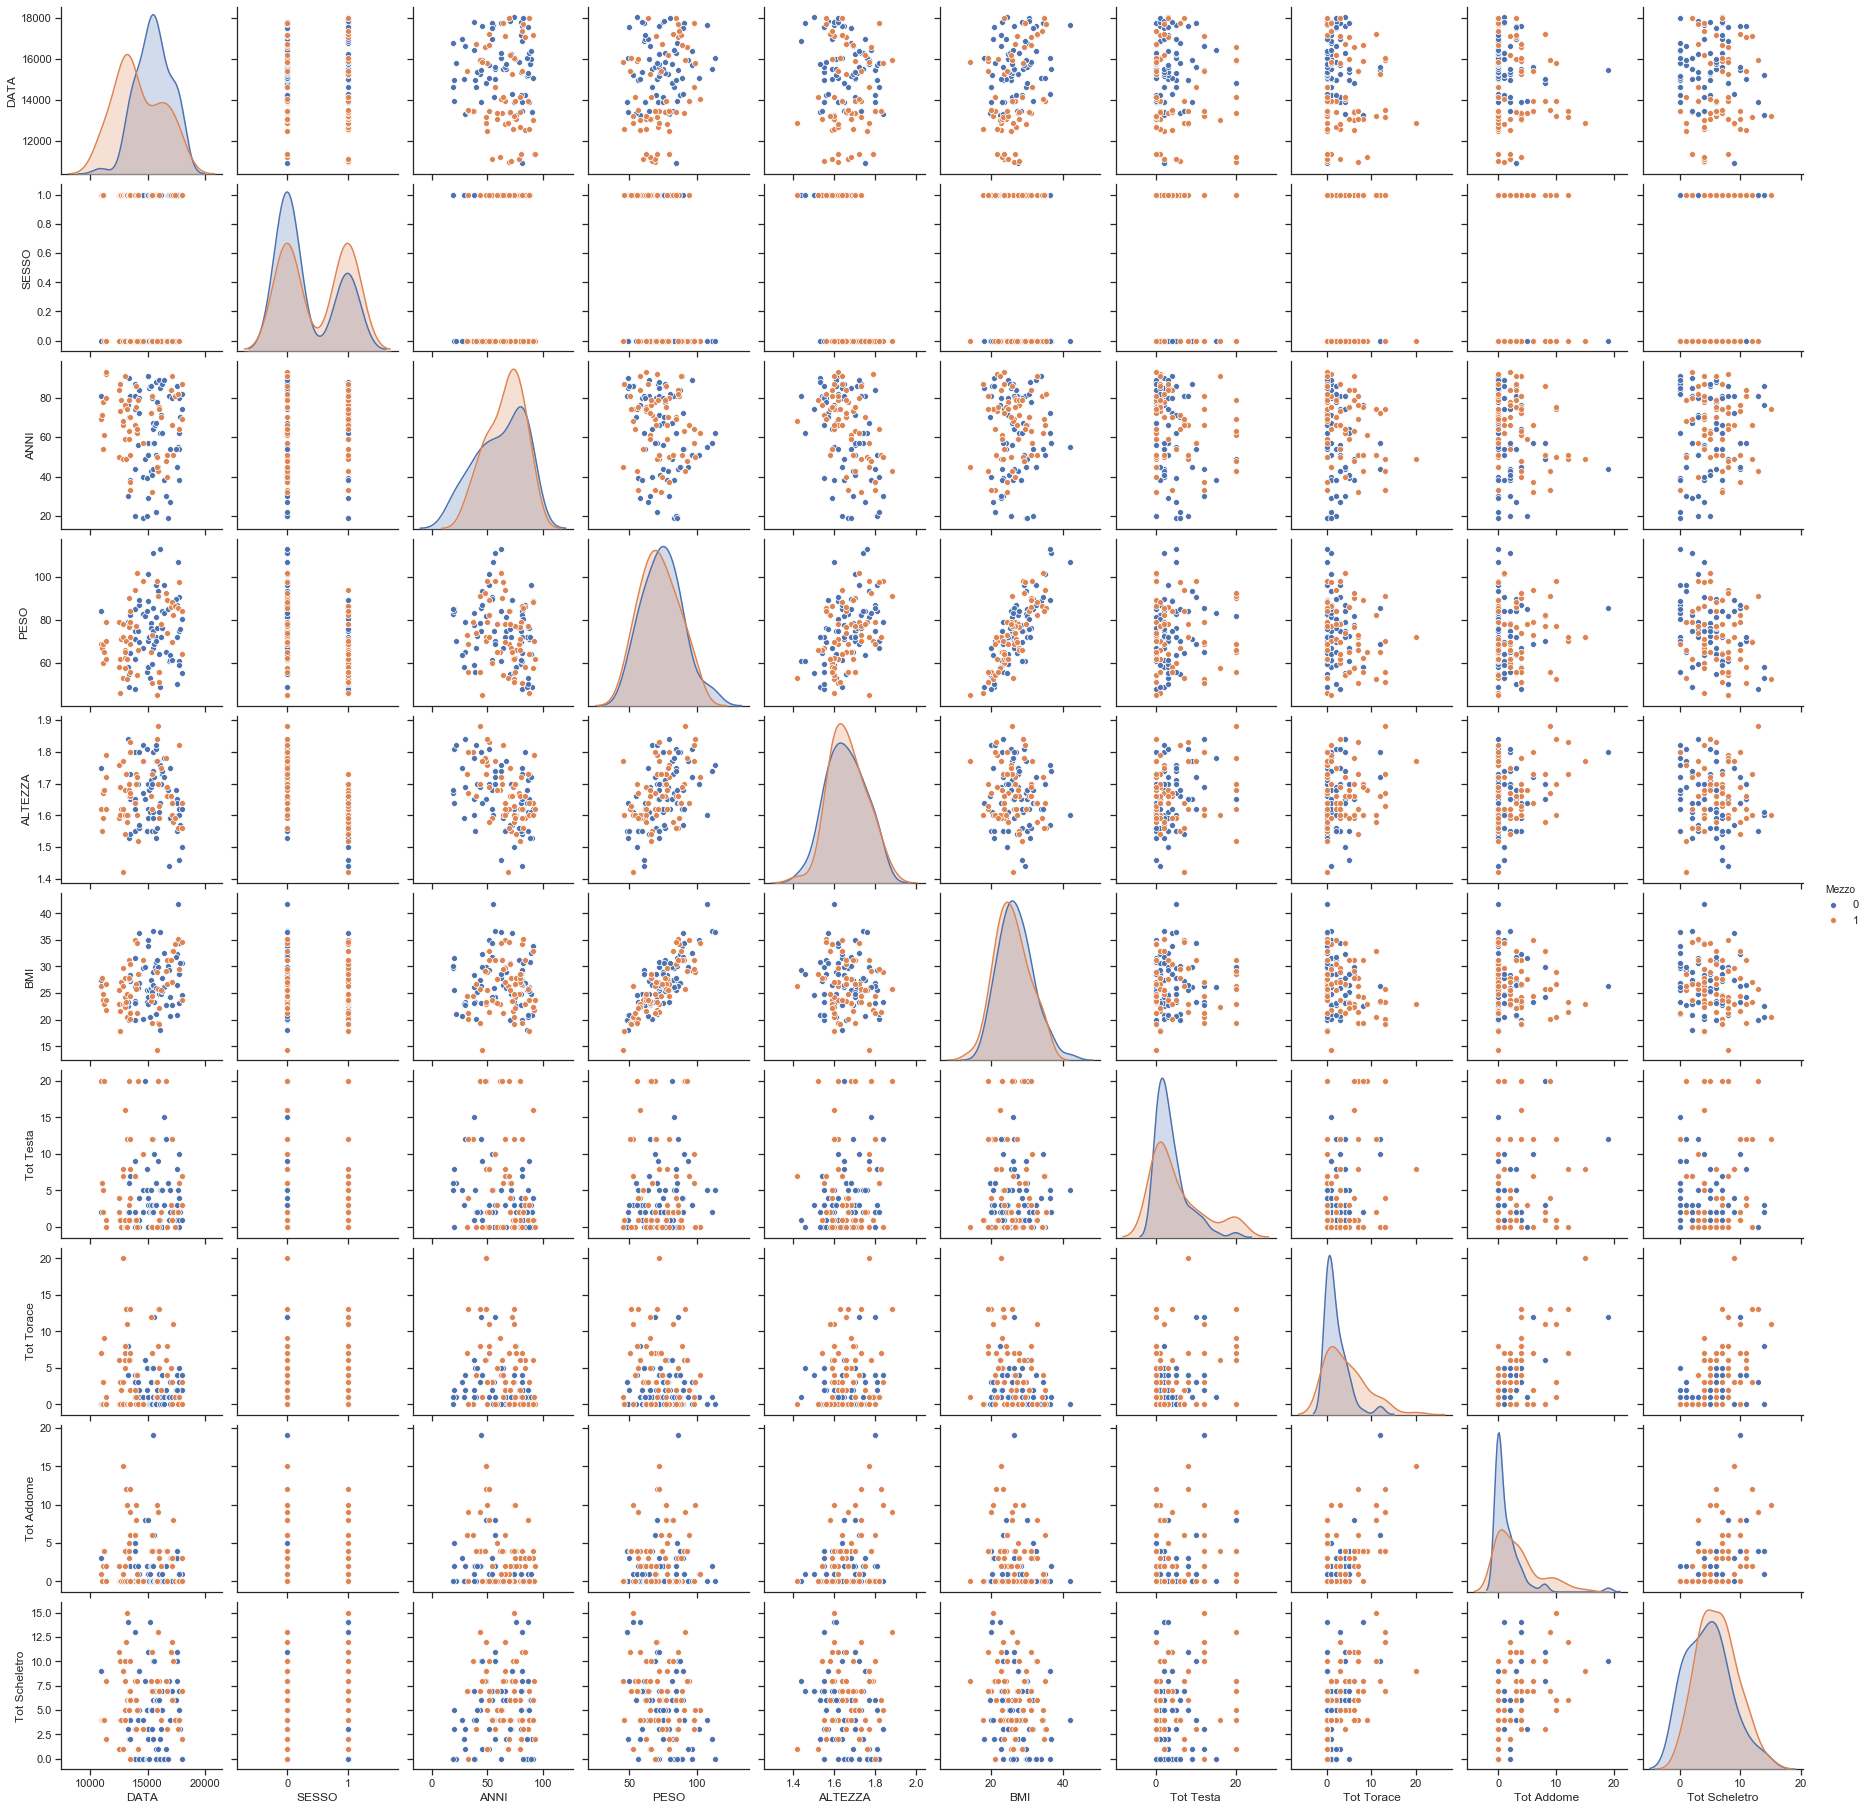

In [3]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
df_pairplot = df[['DATA','SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'BMI', 'Tot Testa', 'Tot Torace', 'Tot Addome', 'Tot Scheletro', 'Mezzo']]
sns.pairplot(df_pairplot, hue='Mezzo', diag_kind="kde",x_vars=df_pairplot.columns[:-1], y_vars=df_pairplot.columns[:-1])
plt.show()

In [4]:
sc = StandardScaler()
X_std = sc.fit_transform(X)

In [5]:
def scatter(x, labels):
    palette = np.array(sns.color_palette("colorblind", 3))

    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot()
    sc = ax.scatter(x[:,0], x[:,1], c=palette[list(labels)], alpha=0.7)
    
    ax.axis('off')

    txts = []
    for i in range(2):
        # Ogni label viene posta nella mediana dei punti corrispondenti.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, [0,1][i], fontsize=18)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    
    return f, ax, sc, txts

In [6]:
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

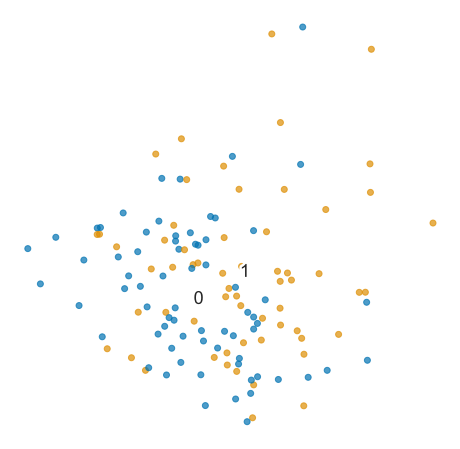

In [7]:
fig_pca, ax_pca, _, _ = scatter(X_pca, y.astype(int))
plt.show()

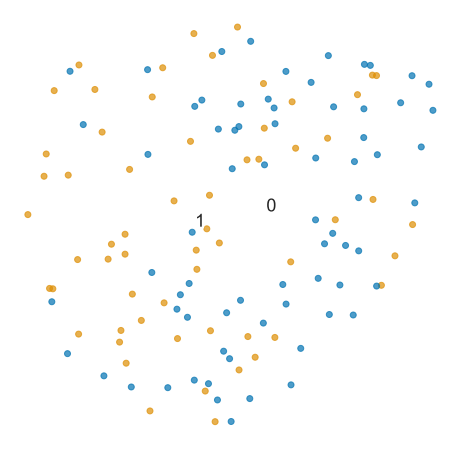

In [8]:
from sklearn.manifold import TSNE

X_tsne = TSNE(perplexity=60, n_iter = 500).fit_transform(X_pca)

fig_tsne, ax_tsne, _, _ = scatter(X_tsne, y.astype(int))
plt.show()

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

params = {'max_iter': [100,1000,5000,10000],
          'hidden_layer_sizes': [[2], [4], [6], [10], [20], [4, 4], [10, 10]],
          'learning_rate_init' : [0.01, 0.2, 0.001],
          'activation': ['identity', 'logistic', 'tanh', 'relu']}

mlp = MLPClassifier()

clf = GridSearchCV(mlp, params, n_jobs=-1, cv=5)
scores = cross_val_score(clf, X_std, y, cv=3)
print("\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores

E:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Accuracy: 0.67 (+/- 0.21)


array([0.68181818, 0.79069767, 0.53488372])

In [10]:
clf.fit(X_std,y)
clf.best_score_

0.7538461538461538

In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

def get_summary(X, y, params):

    ext_fold = StratifiedKFold(n_splits=5, shuffle=True)

    summary = {"Activation" : [], "Learning rate init" : [], "Hidden layer sizes" : [], "Max iter" : [], "Scores" : [], "Test score" : []}

    for infer_indices, test_indices in ext_fold.split(X, y):
        int_fold = StratifiedKFold(n_splits=5, shuffle=True)

        clf = GridSearchCV(estimator=MLPClassifier(), param_grid=params, cv=int_fold, n_jobs=-1)
        clf.fit(X[infer_indices], y.values[infer_indices])

        summary["Test score"].append(clf.best_estimator_.score(X[test_indices], y.values[test_indices]))
        summary["Scores"].append(clf.best_score_)
        summary["Activation"].append(clf.best_params_['activation'])
        summary["Learning rate init"].append(clf.best_params_['learning_rate_init'])
        summary["Hidden layer sizes"].append(clf.best_params_['hidden_layer_sizes'])
        summary["Max iter"].append(clf.best_params_['max_iter'])
        

    return pd.DataFrame(summary)

# Scores con data

In [12]:
data_summary = get_summary(X_std, y, params)
data_summary

E:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,Activation,Learning rate init,Hidden layer sizes,Max iter,Scores,Test score
0,identity,0.001,[6],10000,0.740476,0.692308
1,logistic,0.200,[20],1000,0.779048,0.576923
2,logistic,0.010,[4],100,0.761429,0.730769
3,relu,0.001,[2],5000,0.758571,0.730769
4,relu,0.001,[20],100,0.817619,0.692308


# Scores senza data

In [ ]:
X_no_data = df[['SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'BMI', 'Tot Testa', 'Tot Torace', 'Tot Addome', 'Tot Scheletro']]

sc = StandardScaler()
X_no_data_std = sc.fit_transform(X_no_data)

no_data_summary = get_summary(X_no_data_std, y, params)
no_data_summary

E:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
E:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
